In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm


df = pd.read_csv(r"exoplanet_catalogue.csv")

# modify the dataframe to only contain planets detected via primary transit and radial velocity
det_types = ["Primary Transit", "Radial Velocity"]

new_rows = []

for i in det_types:
    for index, row in df.iterrows():
        if i in row['detection_type']:
            new_row = row
            new_row['detection_type'] = i
            new_rows.append(new_row) 

df1 = pd.DataFrame(new_rows)
print(f"{len(df1)} rows in the dataframe after filtering for primary transit and radial velocity detection types")

# getting our features of interest
features = ["mass", "radius", "orbital_period", "semi_major_axis", "star_mass", "star_radius", "star_teff"]
feat_dict = {}

for i in features:
    feat_dict[i] = df1[i].dropna().values
    print(f"{len(feat_dict[i])} non-nan values in {i} feature")


5769 rows in the dataframe after filtering for primary transit and radial velocity detection types
2828 non-nan values in mass feature
4549 non-nan values in radius feature
5750 non-nan values in orbital_period feature
4208 non-nan values in semi_major_axis feature
5371 non-nan values in star_mass feature
5395 non-nan values in star_radius feature
5541 non-nan values in star_teff feature


In [8]:
df_drop = df.dropna(subset=['mass','radius','semi_major_axis'])
print(df_drop.shape)

(1587, 98)


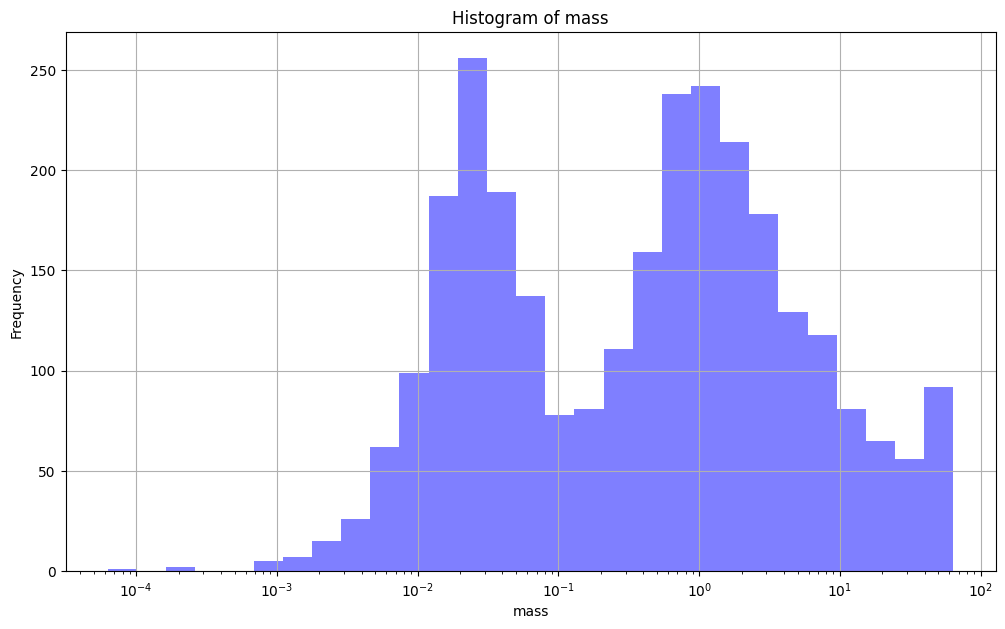

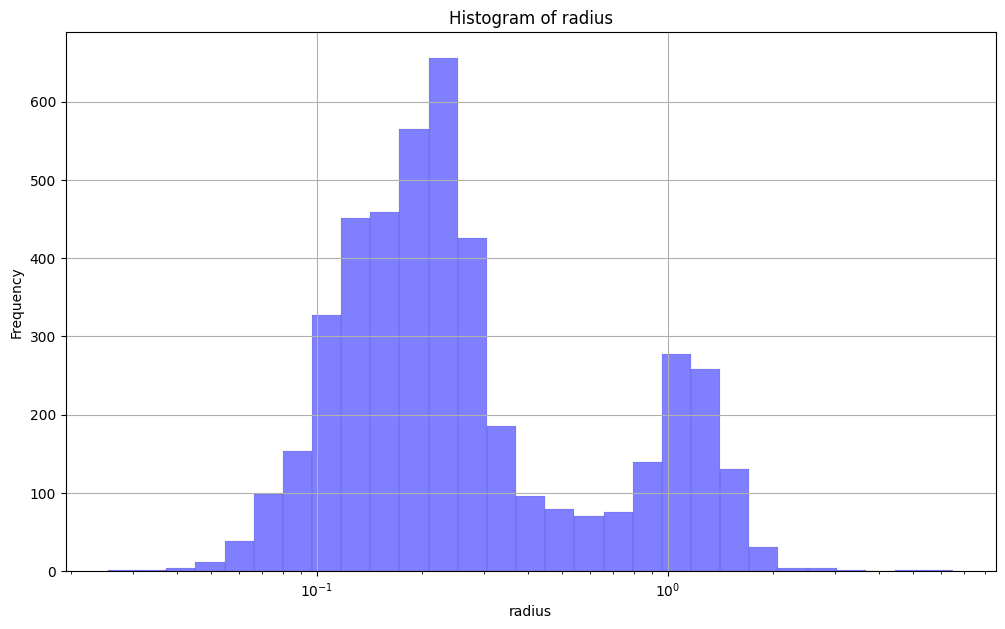

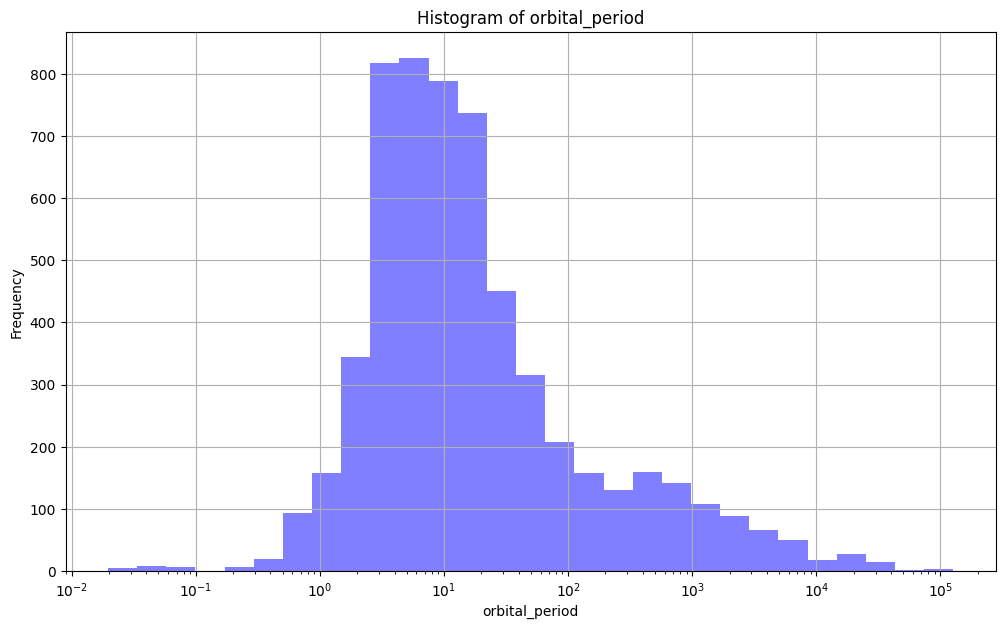

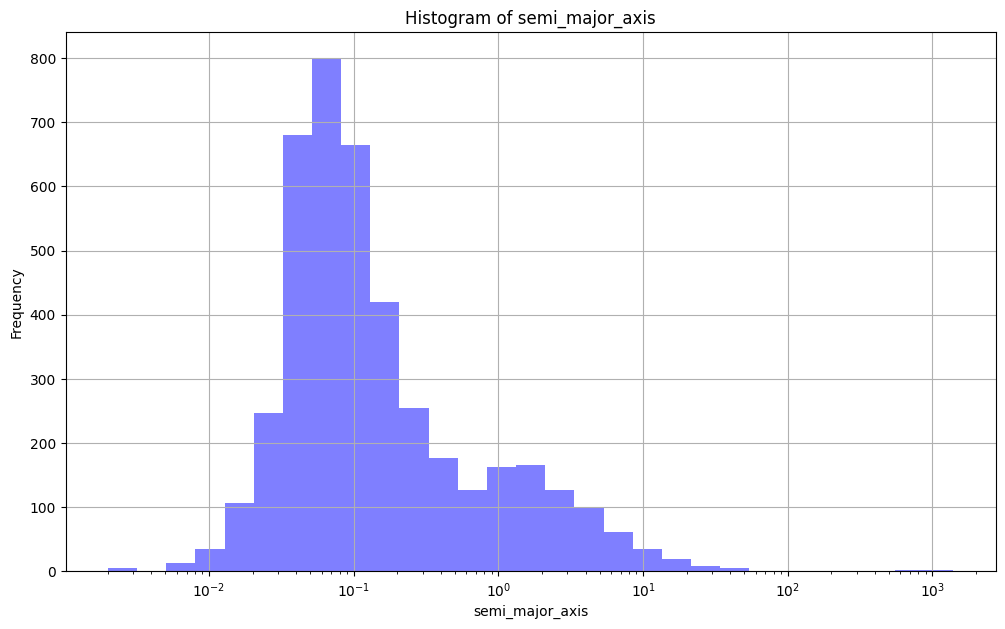

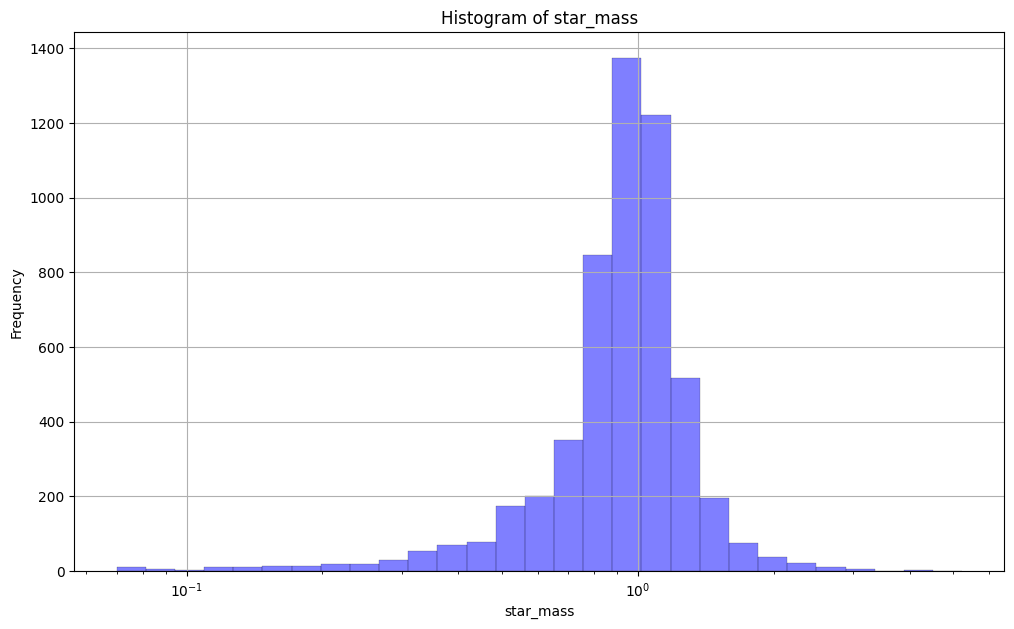

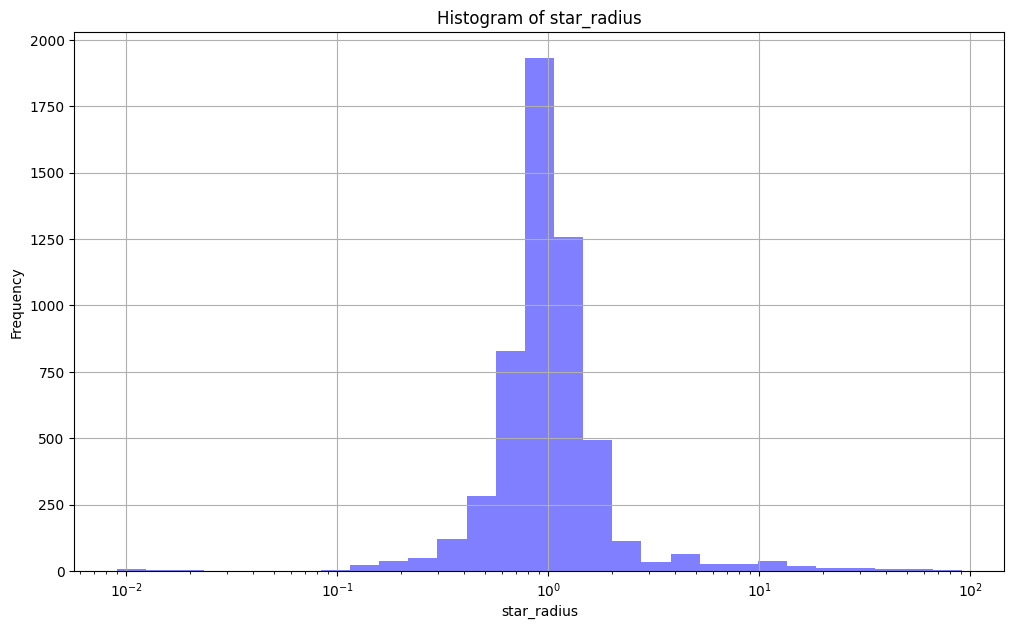

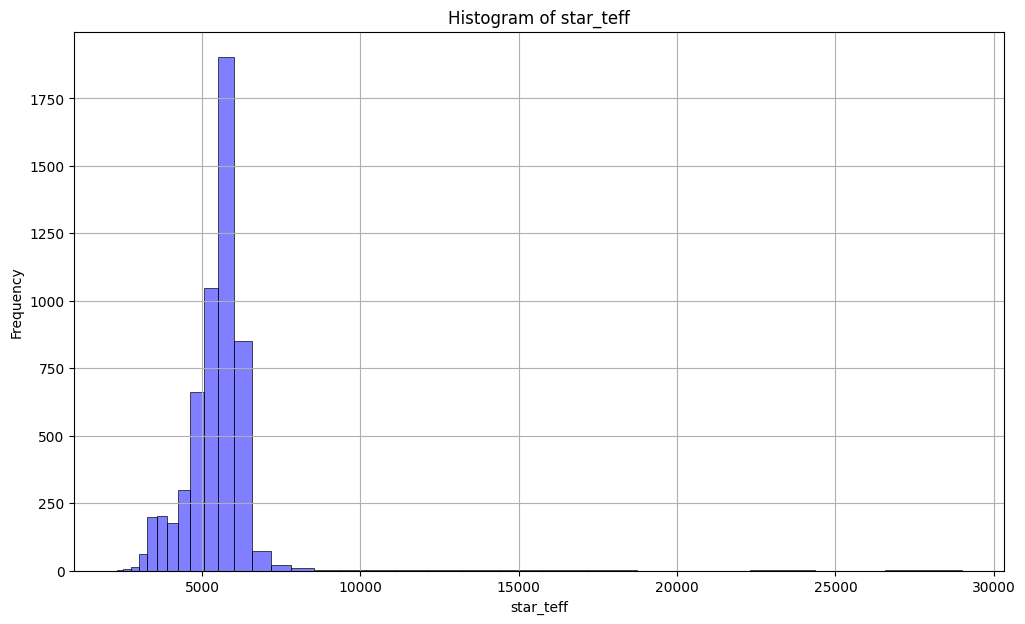

In [2]:
# plotting the a histogram for each feature to determine the distribution
def plot_histogram(data, feature, log = True):
    # Plot both the actual and expected counts
    plt.figure(figsize=(12, 7))

    # Creating bins
    bins = np.geomspace(min(data), max(data), 30)

    sns.histplot(data, bins=bins, color='blue', alpha=0.5,label='Data')  
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid()
    if log:
        plt.xscale('log')   
    plt.show()


for i in features:
    if i == "star_teff":
        plot_histogram(feat_dict[i], i, False)
    else:
        plot_histogram(feat_dict[i], i)


In [3]:
import numpy as np
from scipy.stats import rv_continuous, lognorm

class MixtureLognorm(rv_continuous):
    def __init__(self, dist1, dist2, w, **kwargs):
        super().__init__(**kwargs)
        self.dist1 = dist1
        self.dist2 = dist2
        self.w = w

    def _pdf(self, x):
        return self.w * self.dist1.pdf(x) + (1 - self.w) * self.dist2.pdf(x)

    def _cdf(self, x):
        return self.w * self.dist1.cdf(x) + (1 - self.w) * self.dist2.cdf(x)

    def _rvs(self, *args, size=None, random_state=None):
        rs = random_state  # SciPy’s RNG
        # 1) flip weighted coin:
        u = rs.random_sample(size)
        # 2) handle scalar vs. array cases
        if size is None:
            # single draw
            return ( self.dist1.rvs(random_state=rs)
                     if u < self.w
                     else self.dist2.rvs(random_state=rs) )
        # 3) array draw
        out = np.empty(size)
        mask = (u < self.w)
        # sample component 1 where mask True
        out[mask]  = self.dist1.rvs(size=mask.sum(),      random_state=rs)
        # sample component 2 where mask False
        out[~mask] = self.dist2.rvs(size=(~mask).sum(),   random_state=rs)
        return out



Fitting the mass distribution to a bimodal lognorm model

 For 1th regime: Lognormal parameters: shape=6.3824e-01, loc=-5.3648e-03, scale=2.8877e-02
 For 2th regime: Lognormal parameters: shape=1.7662e+00, loc=9.3406e-02, scale=1.5739e+00
Chi-square statistic: 216.88
Total actual counts: 2828
Total expected counts: 2791.03


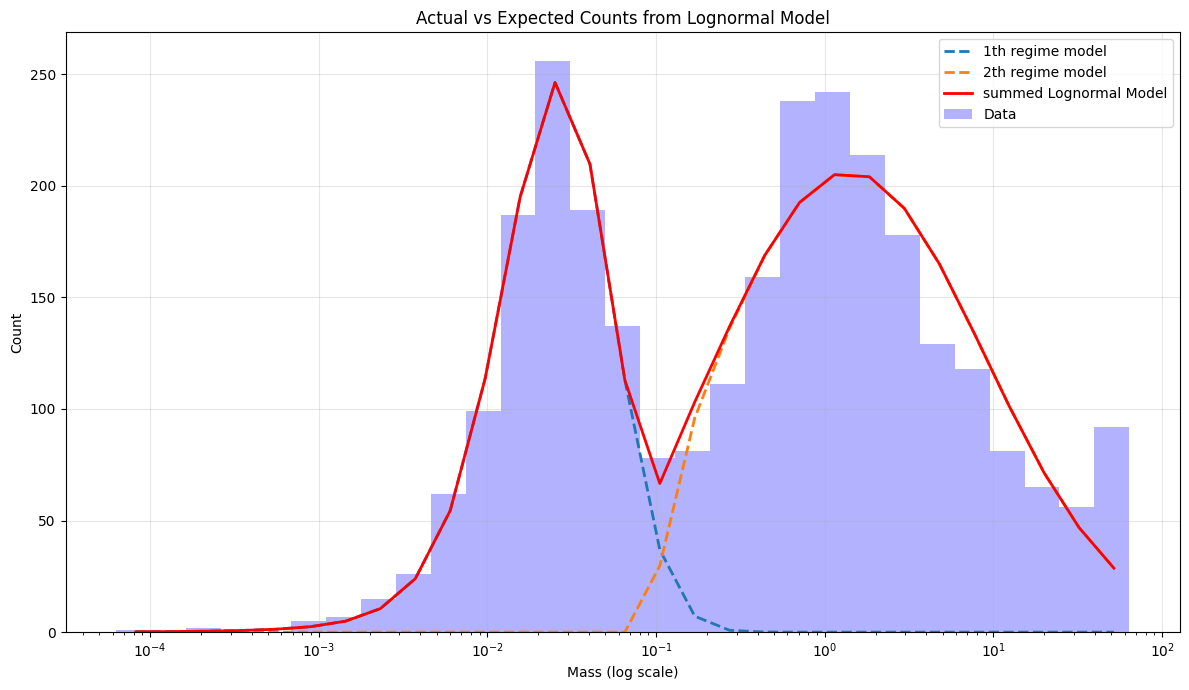

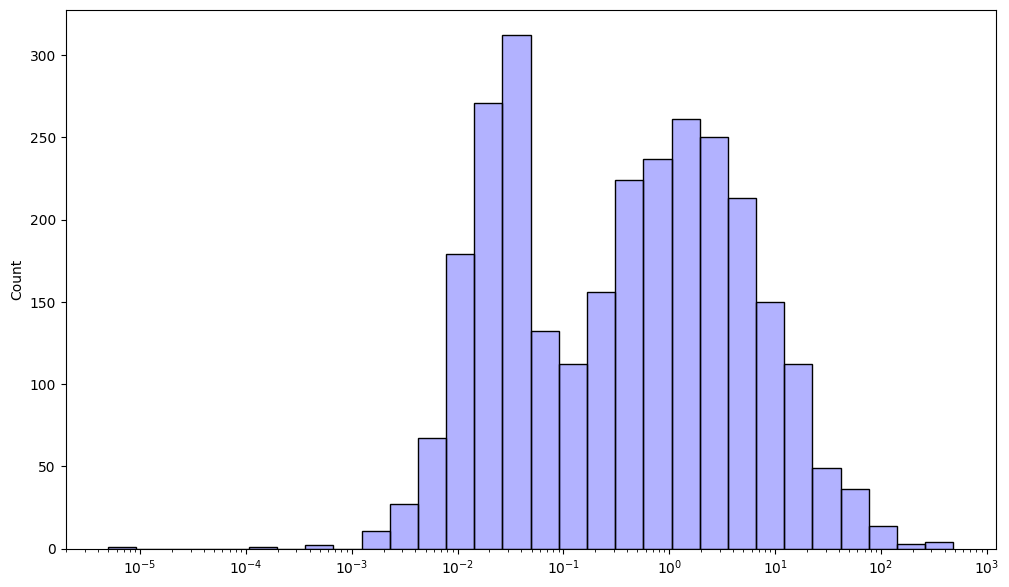

In [4]:
# fitting mass distribution to two lognorm distributions

mass_threshold = 1e-1

mass = feat_dict["mass"]
m1 = feat_dict["mass"][feat_dict["mass"] <= mass_threshold]
m2 = feat_dict["mass"][feat_dict["mass"] > mass_threshold]

# finding the weights of first regime
w = len(m1) / len(mass)

m_regimes = [m1,m2]

# Plot both the actual and expected counts
plt.figure(figsize=(12, 7))

# Creating bins
bins = np.geomspace(min(mass), max(mass), 30)

sns.histplot(mass, bins=bins, color='blue', alpha=0.3,label='Data')  

# Create histogram of the actual data
hist, bin_edges = np.histogram(mass, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Calculate expected counts in each bin based on the fitted PDF
total_expected_counts = []

# to store fitted params
fparams = []

for index,m in enumerate(m_regimes):
  total_counts = len(m)  # total number of counts in this regime

  # Fit lognormal distribution to this regime
  shape, loc, scale = lognorm.fit(m)
  fparams.append((shape, loc, scale))

  expected_counts = np.zeros_like(bin_centers)  # Initialize expected counts array
  for i in range(len(bin_edges) - 1):
    # Find the probability mass in this bin by integrating the PDF
    bin_probability = lognorm.cdf(bin_edges[i+1], shape, loc=loc, scale=scale) - lognorm.cdf(bin_edges[i], shape, loc=loc, scale=scale)

    # Convert probability to expected count
    expected_counts[i] = bin_probability * total_counts

  print(f" For {index+1}th regime: Lognormal parameters: shape={shape:.4e}, loc={loc:.4e}, scale={scale:.4e}")
  plt.plot(bin_centers, expected_counts, '--', linewidth=2, label=f'{index+1}th regime model')
  total_expected_counts.append(np.array(expected_counts))



total_expected_counts = np.array(total_expected_counts)

summed_counts = np.sum(total_expected_counts,axis = 0)
# Plot expected counts based on fitted distribution
plt.plot(bin_centers, summed_counts, 'r-', linewidth=2, label='summed Lognormal Model')

# Use log scale for x-axis
plt.xscale('log')

# Add labels and legend
plt.title('Actual vs Expected Counts from Lognormal Model')
plt.xlabel('Mass (log scale)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate goodness of fit metrics
chi_square = np.sum((hist - summed_counts)**2 / (summed_counts + 1e-10))  # Adding small constant to avoid division by zero
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Total actual counts: {np.sum(hist)}")
print(f"Total expected counts: {np.sum(summed_counts):.2f}")

plt.show()

# creating the model object using Mixturelognorm class
mass_dist = MixtureLognorm(
    lognorm(fparams[0][0], loc=fparams[0][1], scale=fparams[0][2]),
    lognorm(fparams[1][0], loc=fparams[1][1], scale=fparams[1][2]),
    w,
    name='mass_dist'
)


# taking a sample of original dataset size
mass_sample = mass_dist.rvs(size=len(mass), random_state=42)
plt.figure(figsize=(12, 7))
sns.histplot(mass_sample, bins=30, color='blue', alpha=0.3, label='Data', log_scale = True)
plt.show()

Fitting the radius distribution to a bimodal lognorm model

 For 1th regime: Lognormal parameters: shape=4.2653e-01, loc=-1.4367e-02, scale=1.9789e-01
 For 2th regime: Lognormal parameters: shape=3.4898e-01, loc=2.2983e-01, scale=8.8359e-01
Chi-square statistic: 5517.87
Total actual counts: 4549
Total expected counts: 4548.70


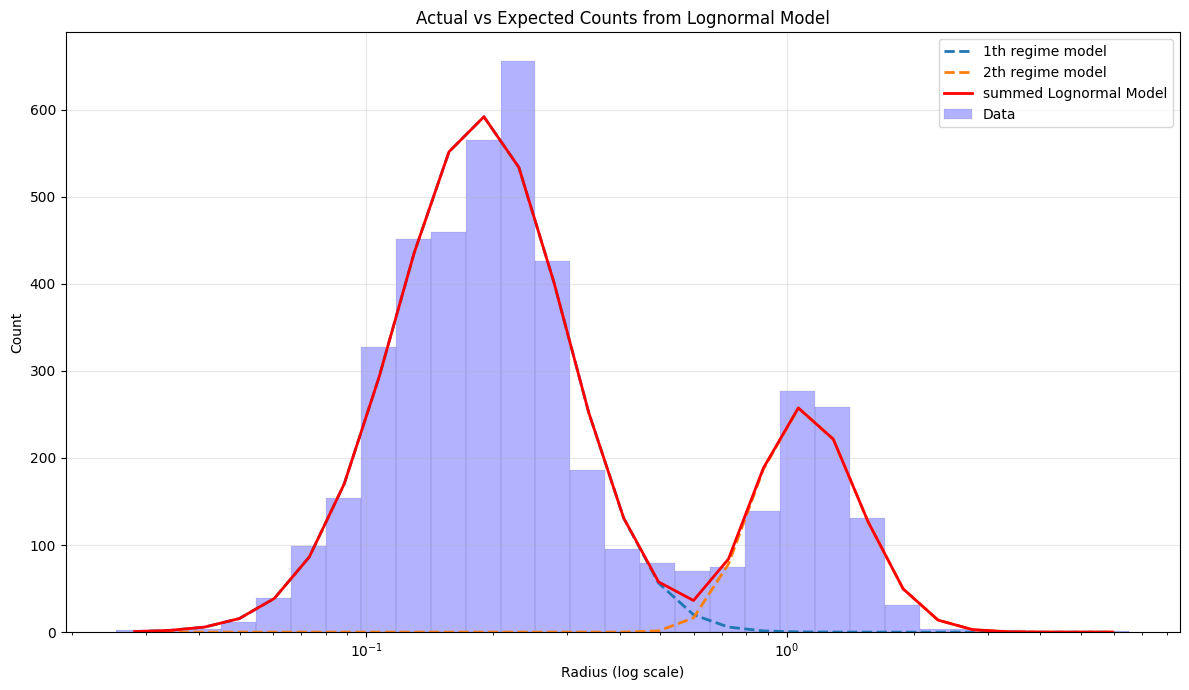

In [5]:
# fitting mass distribution to two lognorm distributions

radius_threshold = 6e-1

radius = feat_dict["radius"]
r1 =     feat_dict["radius"][feat_dict["radius"] <= radius_threshold]
r2 =     feat_dict["radius"][feat_dict["radius"] >  radius_threshold]

r_regimes = [r1,r2]

# Plot both the actual and expected counts
plt.figure(figsize=(12, 7))

# Creating bins
bins = np.geomspace(min(radius), max(radius), 30)

sns.histplot(radius, bins=bins, color='blue', alpha=0.3,label='Data')  

# Create histogram of the actual data
hist, bin_edges = np.histogram(radius, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Calculate expected counts in each bin based on the fitted PDF
total_expected_counts = []


for index,r in enumerate(r_regimes):
  total_counts = len(r)  # total number of counts in this regime

  # Fit lognormal distribution to this regime
  shape, loc, scale = lognorm.fit(r)

  expected_counts = np.zeros_like(bin_centers)  # Initialize expected counts array
  for i in range(len(bin_edges) - 1):
    # Find the probability mass in this bin by integrating the PDF
    bin_probability = lognorm.cdf(bin_edges[i+1], shape, loc=loc, scale=scale) - lognorm.cdf(bin_edges[i], shape, loc=loc, scale=scale)

    # Convert probability to expected count
    expected_counts[i] = bin_probability * total_counts

  print(f" For {index+1}th regime: Lognormal parameters: shape={shape:.4e}, loc={loc:.4e}, scale={scale:.4e}")
  plt.plot(bin_centers, expected_counts, '--', linewidth=2, label=f'{index+1}th regime model')
  total_expected_counts.append(np.array(expected_counts))

total_expected_counts = np.array(total_expected_counts)

summed_counts = np.sum(total_expected_counts,axis = 0)
# Plot expected counts based on fitted distribution
plt.plot(bin_centers, summed_counts, 'r-', linewidth=2, label='summed Lognormal Model')

# Use log scale for x-axis
plt.xscale('log')

# Add labels and legend
plt.title('Actual vs Expected Counts from Lognormal Model')
plt.xlabel('Radius (log scale)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate goodness of fit metrics
chi_square = np.sum((hist - summed_counts)**2 / (summed_counts + 1e-10))  # Adding small constant to avoid division by zero
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Total actual counts: {np.sum(hist)}")
print(f"Total expected counts: {np.sum(summed_counts):.2f}")

plt.show()



For 1th regime: Lognormal parameters: shape=1.2741e+00, loc=-8.8875e-02, scale=9.7368e+00
For 2th regime: Lognormal parameters: shape=1.7459e+00, loc=2.4977e+02, scale=7.8266e+02
Chi-square statistic: 334.91
Total actual counts: 5750
Total expected counts: 5747.64


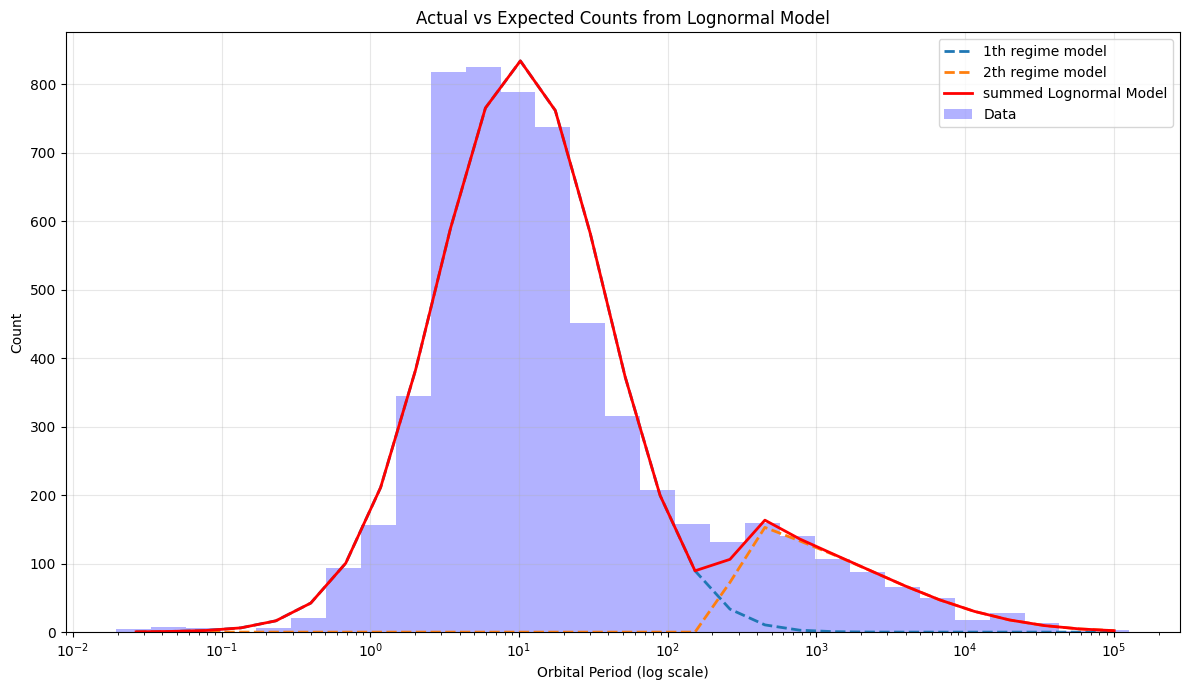

In [6]:
orbital_period_threshold = 2.5e2

orbital_period = feat_dict["orbital_period"]
period_short = feat_dict["orbital_period"][feat_dict["orbital_period"] <= orbital_period_threshold]
period_long = feat_dict["orbital_period"][feat_dict["orbital_period"] > orbital_period_threshold]

period_regimes = [period_short, period_long]

# Plot both the actual and expected counts
plt.figure(figsize=(12, 7))

# Creating bins
bins = np.geomspace(min(orbital_period), max(orbital_period), 30)

sns.histplot(orbital_period, bins=bins, color='blue', alpha=0.3, label='Data')  

# Create histogram of the actual data
hist, bin_edges = np.histogram(orbital_period, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Calculate expected counts in each bin based on the fitted PDF
total_expected_counts = []

for index, period_regime in enumerate(period_regimes):
    total_counts = len(period_regime)  # total number of counts in this regime

    # Fit lognormal distribution to this regime
    shape, loc, scale = lognorm.fit(period_regime)

    expected_counts = np.zeros_like(bin_centers)  # Initialize expected counts array
    for i in range(len(bin_edges) - 1):
        # Find the probability mass in this bin by integrating the PDF
        bin_probability = lognorm.cdf(bin_edges[i+1], shape, loc=loc, scale=scale) - lognorm.cdf(bin_edges[i], shape, loc=loc, scale=scale)

        # Convert probability to expected count
        expected_counts[i] = bin_probability * total_counts

    print(f"For {index+1}th regime: Lognormal parameters: shape={shape:.4e}, loc={loc:.4e}, scale={scale:.4e}")
    plt.plot(bin_centers, expected_counts, '--', linewidth=2, label=f'{index+1}th regime model')
    total_expected_counts.append(np.array(expected_counts))

total_expected_counts = np.array(total_expected_counts)

summed_counts = np.sum(total_expected_counts, axis=0)
# Plot expected counts based on fitted distribution
plt.plot(bin_centers, summed_counts, 'r-', linewidth=2, label='summed Lognormal Model')

# Use log scale for x-axis
plt.xscale('log')

# Add labels and legend
plt.title('Actual vs Expected Counts from Lognormal Model')
plt.xlabel('Orbital Period (log scale)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate goodness of fit metrics
chi_square = np.sum((hist - summed_counts)**2 / (summed_counts + 1e-10))  # Adding small constant to avoid division by zero
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Total actual counts: {np.sum(hist)}")
print(f"Total expected counts: {np.sum(summed_counts):.2f}")

plt.show()

For 1th regime: Lognormal parameters: shape=8.5654e-01, loc=-1.6850e-04, scale=8.1517e-02
For 2th regime: Lognormal parameters: shape=1.3660e+00, loc=6.7329e-01, scale=1.3720e+00
Chi-square statistic: 1972.42
Total actual counts: 4208
Total expected counts: 4207.96


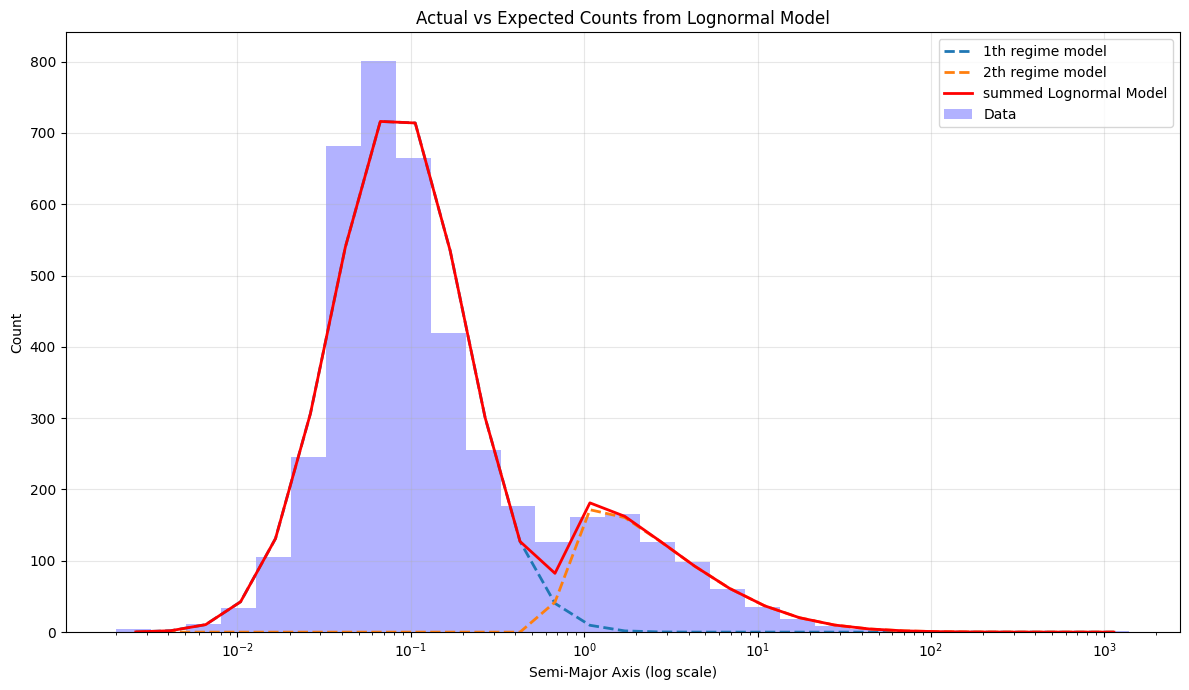

In [7]:
semi_major_axis_threshold = 7e-1

semi_major_axis = feat_dict["semi_major_axis"]
sma_small = feat_dict["semi_major_axis"][feat_dict["semi_major_axis"] <= semi_major_axis_threshold]
sma_large = feat_dict["semi_major_axis"][feat_dict["semi_major_axis"] > semi_major_axis_threshold]

sma_regimes = [sma_small, sma_large]

# Plot both the actual and expected counts
plt.figure(figsize=(12, 7))

# Creating bins
bins = np.geomspace(min(semi_major_axis), max(semi_major_axis), 30)

sns.histplot(semi_major_axis, bins=bins, color='blue', alpha=0.3, label='Data')  

# Create histogram of the actual data
hist, bin_edges = np.histogram(semi_major_axis, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Calculate expected counts in each bin based on the fitted PDF
total_expected_counts = []

for index, sma_regime in enumerate(sma_regimes):
    total_counts = len(sma_regime)  # total number of counts in this regime

    # Fit lognormal distribution to this regime
    shape, loc, scale = lognorm.fit(sma_regime)

    expected_counts = np.zeros_like(bin_centers)  # Initialize expected counts array
    for i in range(len(bin_edges) - 1):
        # Find the probability mass in this bin by integrating the PDF
        bin_probability = lognorm.cdf(bin_edges[i+1], shape, loc=loc, scale=scale) - lognorm.cdf(bin_edges[i], shape, loc=loc, scale=scale)

        # Convert probability to expected count
        expected_counts[i] = bin_probability * total_counts

    print(f"For {index+1}th regime: Lognormal parameters: shape={shape:.4e}, loc={loc:.4e}, scale={scale:.4e}")
    plt.plot(bin_centers, expected_counts, '--', linewidth=2, label=f'{index+1}th regime model')
    total_expected_counts.append(np.array(expected_counts))

total_expected_counts = np.array(total_expected_counts)

summed_counts = np.sum(total_expected_counts, axis=0)
# Plot expected counts based on fitted distribution
plt.plot(bin_centers, summed_counts, 'r-', linewidth=2, label='summed Lognormal Model')

# Use log scale for x-axis
plt.xscale('log')

# Add labels and legend
plt.title('Actual vs Expected Counts from Lognormal Model')
plt.xlabel('Semi-Major Axis (log scale)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate goodness of fit metrics
chi_square = np.sum((hist - summed_counts)**2 / (summed_counts + 1e-10))  # Adding small constant to avoid division by zero
print(f"Chi-square statistic: {chi_square:.2f}")
print(f"Total actual counts: {np.sum(hist)}")
print(f"Total expected counts: {np.sum(summed_counts):.2f}")

plt.show()